In [2]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from pinns import Domain
from pinns.samplers import RandomSampler, ConstantSampler, DataSampler

path = 'C:/Программы/github/pinns/examples/data/diffusion 1d/'

def get_data(path):
    init = torch.tensor(np.load(path + 'init_data.npy'))
    left = torch.tensor(np.load(path + 'left_data.npy'))
    right = torch.tensor(np.load(path + 'right_data.npy'))
    
    return ([init[:,  :2], left[:,  :2], right[:,  :2]], 
            [init[:, [2]], left[:, [2]], right[:, [2]]])

pts, data = get_data(path)
constraints_sampler = ConstantSampler((pts, data))

domain = Domain({'t': [0, 0.5], 'x': [0, 1]})
collocation_sampler = RandomSampler(domain, 2048)

test_data_sampler = DataSampler(path + 'solution.npy', 1024, 2)

In [5]:
from pinns.derivatives import Derivative

d = Derivative(method='autograd')

D = 0.5
def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred
    ):
    
    # We do not need left and right because we are solving 
    # Dirichlet problem and we just compare predictions and 
    # solution. If we solve Cauchy or Robin problem, we 
    # need to calculate derivatives at boundary points.
    
    init_pts, left_pts, right_pts = cstr_pts
    init_pred, left_pred, right_pred = cstr_pred
    init_vals, left_vals, right_vals = cstr_vals
    
    t, x = coll_pts['t'], coll_pts['x']
    
    def initial_loss():
        return torch.mean(torch.square(init_pred - init_vals))
    
    def left_loss():
        return torch.mean(torch.square(left_pred - left_vals))
    
    def right_loss():
        return torch.mean(torch.square(right_pred - right_vals))
    
    def pde_loss(u, t, x):
        ut  = d(u,  t)
        uxx = d(u,  x, orders = 2)
        return torch.mean(torch.square(ut - D * uxx))
    
    return (
        initial_loss(), 
        left_loss(), 
        right_loss(), 
        pde_loss(coll_pred, t, x)
    )

In [6]:
def get_ip_data(N):
    pts, data = test_data_sampler(full=True)
    if N >= len(pts):
        step = 1
    else:
        step = len(pts) // N
    pts = {
        't': pts[::step,[0]].requires_grad_(True),
        'x': pts[::step,[1]].requires_grad_(True)
    }
    return pts, data[::step, :]

ip_pts, ip_vals = get_ip_data(1000)

def residual(u, tx):
    
    t, x = tx['t'], tx['x']
    ut  = d(u, t)
    uxx = d(u, x, orders = 2)
    
    return torch.square(ut - D * uxx)

In [7]:
from pinns import Trainer
from pinns.models import FF
from pinns.activations import Swish
from pinns.optimizers import Adam
from pinns.analyze import InformationPropagation
from pinns.metrics import l2

pinn = FF([2, 64, 64, 1], activ=nn.Tanh())

adam = Adam(pinn, lr = 1e-2)

ip = InformationPropagation(
    points = ip_pts, 
    values = ip_vals,
    domain = domain, 
    strategy = 'both',
    compute_every = 25,
    residual = residual,
    group_at_finish = True
)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs = [0.75, 0.75, 0.75, 0.25],
    analyzers = [ip]
)

num_iters = 2500
    
trainer.train(
    num_iters=num_iters,
    optimizers=[(0, adam)],
    validate_every=1,
    metrics=[l2],
    test_sampler = test_data_sampler,
    )

  0%|          | 0/2500 [00:00<?, ?it/s]

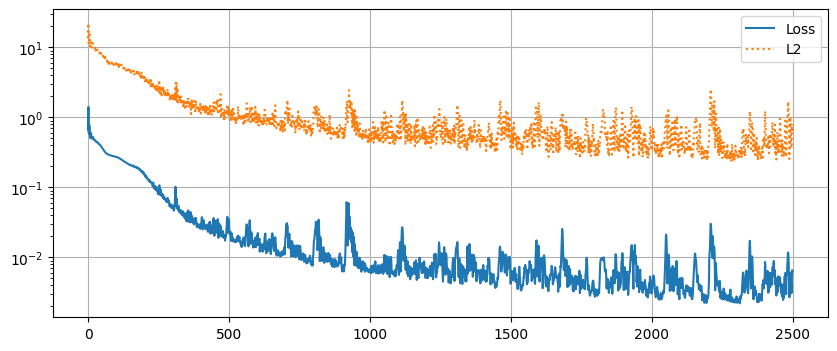

In [8]:
trainer.plot(error_names = ['L2'])

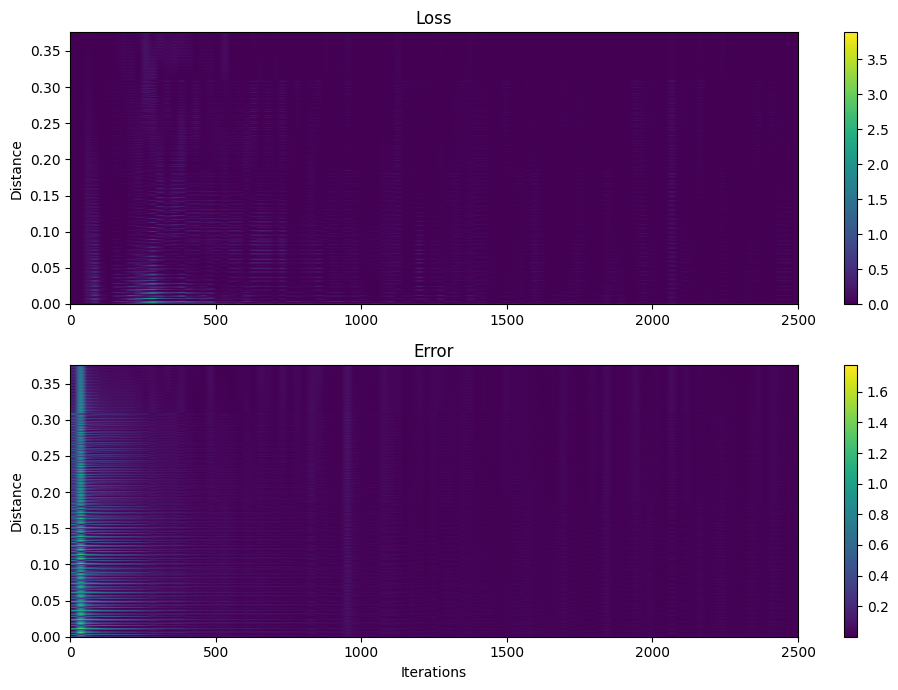

In [9]:
ip.plot(figsize=(10, 7), iterations=trainer.iter)